In [1]:
# Import all the functions you need
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sys
import os
from pathlib import Path

# Comment here to add in for either mac or linux computer
if os.environ['SHELL'] == '/bin/bash':   # for linux
    sys.path.extend(['/data/GitHub/NeuroPy']) 
    sys.path.extend(['/data/GitHub/TraceFC/'])
else:    # For mac laptop
    sys.path.extend(['/Users/nkinsky/Documents/UM/GitHub/NeuroPy'])
    sys.path.extend(['/Users/nkinsky/Documents/UM/GitHub/TraceFC'])

from neuropy import core
from neuropy.io import (optitrackio,
                        dlcio,
                        )
from neuropy.io.neuroscopeio import NeuroscopeIO
from neuropy.io.binarysignalio import BinarysignalIO 
from neuropy.io.miniscopeio import MiniscopeIO
from neuropy.core import Epoch
from neuropy.utils import plot_util
from neuropy.plotting.spikes import plot_raster
from neuropy.plotting.signals import plot_signal_w_epochs


In [2]:
# Define a class for a typical recording or set of recordings
class ProcessData:
    def __init__(self, basepath):
        basepath = Path(basepath)
        self.basepath = basepath
        xml_files = sorted(basepath.glob("*.xml"))
        assert len(xml_files) == 1, "Found more than one .xml file"
        
        fp = xml_files[0].with_suffix("")
        self.filePrefix = fp
        
        self.recinfo = NeuroscopeIO(xml_files[0])
        eegfiles = sorted(basepath.glob('*.eeg'))
        assert len(eegfiles) == 1, "Fewer/more than one .eeg file detected"
        self.eegfile = BinarysignalIO(eegfiles[0], n_channels=self.recinfo.n_channels,
                                     sampling_rate=self.recinfo.eeg_sampling_rate,
                                     )
        try:
            self.datfile = BinarysignalIO(eegfiles[0].with_suffix('.dat'),
                                         n_channels=self.recinfo.n_channels,
                                         sampling_rate=self.recinfo.dat_sampling_rate,
                                         )
        except FileNotFoundError:
            print('No dat file found, not loading')
                
        
    def __repr__(self) -> str:
        return f"{self.__class__.__name__}({self.recinfo.source_file.name})"
    
def sess_use(basepath=os.getcwd()):

    return ProcessData(basepath)

In [3]:
sess = sess_use()
print(sess.recinfo)

filename: /data2/Trace_FC/Recording_Rats/Han/2022_08_03_training/Han_training.xml 
# channels: 35
sampling rate: 30000
lfp Srate (downsampled): 1250



In [4]:
print(sess.eegfile)

duration: 12444.12 seconds 
duration: 3.46 hours 



# Preprocess Ephys data
Identify artifacts:  
- disconnects  
- filtering  
  
Send to event files to check in Neuroscope  
Write `dead_times.txt` file for spyking-circus and `artifacts.npy` file for my own analysis.

### Identify disconnect and motion artifacts

In [30]:
from neuropy.analyses.artifact import detect_artifact_epochs
signal = sess.eegfile.get_signal()
buffer_add = 0.1  # seconds, None = don't add

art_epochs_file = sess.filePrefix.with_suffix(".art_epochs.npy")
if art_epochs_file.exists():
    art_epochs = Epoch(epochs=None, file=art_epochs_file)
    print('Existing artifact epochs file loaded')
else:
    art_epochs = detect_artifact_epochs(signal, thresh=6, 
                                    edge_cutoff=1, merge=6)

    if buffer_add is not None:  # Add in buffer to prevent erroneous detection of start/stop of artifact as SWRs
        art_epochs.add_epoch_buffer(buffer_add)
    sess.recinfo.write_epochs(epochs=art_epochs, ext='art')
art_epochs

Existing artifact epochs file loaded


17 epochs
Snippet: 
        start       stop label
0   159.8936   169.9824      
1   408.4080   417.0392      
2   859.9032   861.1408      
3  1131.7512  1133.0208      
4  1388.4056  1389.6752      

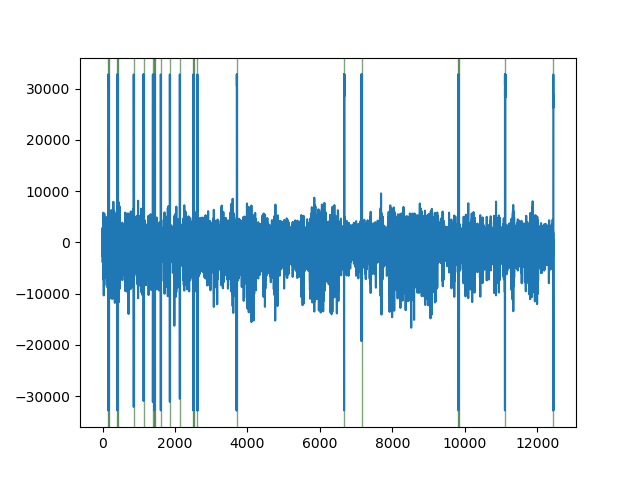

In [32]:
%matplotlib widget
_, ax = plt.subplots()
ax.plot(signal.time, signal.traces[10])

for start, stop in zip(art_epochs.starts, art_epochs.stops):
    ax.axvspan(start, stop, color=[0, 0.3, 0, 0.5])


##  Write artifacts to dead file for spyking circus

In [ ]:
from neuropy.io.spykingcircusio import SpykingCircusIO

SpykingCircusIO.write_epochs(sess.basepath / 'dead_times.txt', 
                            art_epochs)

In [ ]:
# combined_epochs = epochs_test.save(sess.filePrefix.with_suffix('.art_epochs.npy'))

## Define probe group

/data2/Trace_FC/Recording_Rats/Han/2022_08_03_training/Han_training.probegroup.npy saved


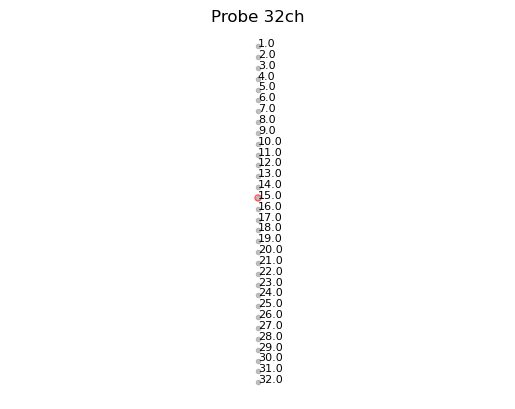

In [5]:
from neuropy.core import Shank, Probe, ProbeGroup
from neuropy.plotting import plot_probe
shank = Shank()
shank = shank.auto_generate(columns=1, contacts_per_column=32, xpitch=0,
                   ypitch=50, channel_id=np.arange(32, 0, -1))
shank.set_disconnected_channels([15])
probe = Probe(shank)
prbgrp = ProbeGroup()
prbgrp.add_probe(probe)
plot_probe(prbgrp)
prbgrp.filename = sess.filePrefix.with_suffix(".probegroup.npy")
prbgrp.save(prbgrp.filename)
sess.prbgrp = prbgrp

# Process spikes

In [6]:
from neuropy.io.phyio import PhyIO
sess.phy = PhyIO(dirname=sorted(sess.basepath.glob("**/*.GUI"))[0])

id column does not exist in cluster_info.tsv. Using cluster_id column instead.


In [42]:
sess.neurons.neuron_type

0     6.0
1     1.0
2     1.0
3     1.0
4     1.0
5     NaN
6     1.0
7     NaN
8     6.0
9     6.0
10    6.0
11    0.0
12    1.0
13    1.0
14    1.0
Name: q, dtype: float64

In [8]:
print( f'last spike time = {np.max([a.max() for a in sess.phy.spiketrains])}')
print(f'recording duration = {sess.eegfile.duration}')

last spike time = 12436.9841
recording duration = 12444.116


In [ ]:
# Sample code to select out CA1 pyramidal cells vs. overlying cortical cells.
# pyr_bool = np.bitwise_and(sess.phy.cluster_info['depth'] >= 100, sess.phy.cluster_info['depth'] <= 450)
# cort_bool = np.bitwise_not(pyr_bool)

In [7]:
from neuropy.core.neurons import Neurons
sess.neurons = Neurons(sess.phy.spiketrains, t_stop=sess.eegfile.duration, sampling_rate=30000,
                      neuron_type=sess.phy.cluster_info['q'])
# npyr = pyr_bool.sum()
# print('First ' + str(npyr) + ' neurons are pyramidal')
# trains_all = np.concatenate((sess.phy.spiketrains[pyr_bool], sess.phy.spiketrains[cort_bool]))
# sess.all_neurons = Neurons(trains_all, t_stop=sess.eegfile.duration, sampling_rate=1,
#                       neuron_type=sess.phy.cluster_info['q'])

<Axes: xlabel='Time (s)', ylabel='Neurons'>

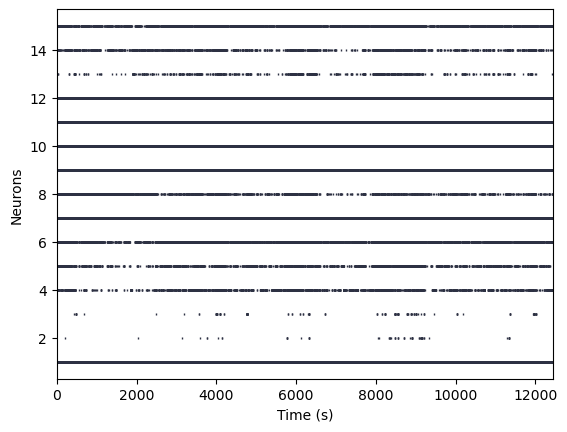

In [9]:
%matplotlib inline
from neuropy.plotting.spikes import plot_raster
plot_raster(sess.neurons)

In [10]:
# Output to .clu and .res files for neuroscope
sess.recinfo.write_neurons(sess.neurons)

PosixPath('/data2/Trace_FC/Recording_Rats/Han/2022_08_03_training/Han_training.clu.1')

# Detect SWRs

In [39]:
# NRK - this does not seem to be doing a good job - too few ripples!
from neuropy.analyses.oscillations import detect_ripple_epochs
ripple_channel = 5
thresh = (3, None)  # conservative but good
ripple_epochs = detect_ripple_epochs(signal, prbgrp, thresh=thresh, ripple_channel=ripple_channel, ignore_epochs=art_epochs)
long_ripple_epochs = detect_ripple_epochs(signal, prbgrp, thresh=thresh, ripple_channel=ripple_channel, mindur=0.3, maxdur=0.6,
                                          ignore_epochs=art_epochs)
short_ripple_epochs = detect_ripple_epochs(signal, prbgrp, thresh=thresh, ripple_channel=ripple_channel, mindur=0.05, maxdur=0.3,
                                           ignore_epochs=art_epochs)

Selected channels for ripples: [5]
4167 epochs remaining with durations within (0.05,0.45)
Selected channels for ripples: [5]
43 epochs remaining with durations within (0.3,0.6)
Selected channels for ripples: [5]
4130 epochs remaining with durations within (0.05,0.3)


### Write to files

In [40]:
ripple_epochs.source_file = sess.filePrefix.with_suffix(".ripple.npy")
ripple_epochs.save(ripple_epochs.source_file)
sess.recinfo.write_epochs(epochs=ripple_epochs, ext='swr')

/data2/Trace_FC/Recording_Rats/Han/2022_08_03_training/Han_training.ripple.npy saved


In [ ]:
# plot stuff!
%matplotlib widget
_, ax = plt.subplots()
ax.plot(signal.time, signal.traces[5])

for start, stop in zip(ripple_epochs.starts, ripple_epochs.stops):
    ax.axvspan(start, stop, color=[0, 0.3, 0, 0.5])


In [ ]:
type(ripple_epochs)

In [ ]:
# Output potential ripple epochs to neuroscope
sess.recinfo.write_epochs(ripple_epochs, ext="swr")

# Detect Sharp Waves 

In [ ]:
# Similar flow to SWR detection but using a different function in neuropy.analyses.oscillation

In [ ]:
from neuropy.analyses.oscillations import detect_sharpwave_epochs
swave_channel=11
sharpwave_epochs = detect_sharpwave_epochs(signal, prbgrp, sharpwave_channel=swave_channel, ignore_epochs=art_epochs)

In [ ]:
type(sharpwave_epochs)

In [ ]:
sess.recinfo.write_epochs(sharpwave_epochs, ext="sharpwave")

# Detect Theta epochs

In [ ]:
signal = sess.eegfile.get_signal()

In [ ]:
from neuropy.analyses.oscillations import detect_theta_epochs
mindur=0.25
maxdur=20
thresh = (0.5, 3.5)
sigma = 0.125
edge_cutoff = 0.25
theta_channel = 5

# use this if you don't know theta channel
if theta_channel is None:
    theta_epochs, theta_power = detect_theta_epochs(signal, prbgrp, mindur=mindur, maxdur=maxdur, thresh=thresh, 
                                                    edge_cutoff=edge_cutoff, ignore_epochs=art_epochs, return_power=True)
else:
    signal_use = signal.time_slice(channel_id=theta_channel)
    theta_epochs, theta_power = detect_theta_epochs(signal_use, probegroup=None, mindur=mindur, maxdur=maxdur, thresh=thresh, 
                                                    edge_cutoff=edge_cutoff, ignore_epochs=art_epochs, return_power=True)

In [ ]:
# # Parameter exploration
# # These look good for Django Recall2 session.  Keep on refining.
# from neuropy.analyses.oscillations import _detect_freq_band_epochs
# channel_use = 55
# ignore_epochs = art_epochs
# mindur = 0.25
# maxdur = 20
# thresh = (0, 3.5)
# freq_band = (5, 12)
# sigma = 0.125
# edge_cutoff = 0.25

# traces = signal.time_slice(channel_id=channel_use).traces.reshape(1, -1)
# if ignore_epochs is not None:
#     ignore_times = ignore_epochs.as_array()
# else:
#     ignore_times = None

# theta_epochs2, theta_power2 = _detect_freq_band_epochs(
#     signals=traces,
#     freq_band=freq_band,
#     thresh=thresh,
#     mindur=mindur,
#     maxdur=maxdur,
#     mergedist=0.5,
#     fs=signal.sampling_rate,
#     ignore_times=ignore_times,
#     sigma=sigma,
#     edge_cutoff=edge_cutoff,
#     return_power=True,
# )

In [ ]:
# # Now try to get power in theta for whole session
# import neuropy.utils.signal_process as signal_process
# from scipy.ndimage import gaussian_filter1d
# channel_use = 55
# window = 10
# overlap = 5
# freq_band = (5, 12)
# thresh = (0.5, 2)
# sigma = 0.125

# signal_use = signal.time_slice(channel_id=channel_use).traces
# fs = signal.sampling_rate

# lf, hf = freq_band
# dt = 1 / fs
# smooth = lambda x: gaussian_filter1d(x, sigma=sigma / dt, axis=-1)
# lowthresh, highthresh = thresh

# # Because here one shank is selected per shank, based on visualization:
# # mean: very conservative in cases where some shanks may not have that strong ripple
# # max: works well but may have ocassional false positives
# power = np.zeros(signal_use.shape[1])
# for sig in signal_use:
#     yf = signal_process.filter_sig.bandpass(sig, lf=lf, hf=hf, fs=fs)
#     # zsc_chan = smooth(stats.zscore(np.abs(signal_process.hilbertfast(yf))))
#     # zscsignal[sig_i] = zsc_chan
#     power += np.abs(signal_process.hilbertfast(yf))

# # mean and smooth
# power = smooth(power / signal_use.shape[0])

In [ ]:
# Now plot these epochs for sanity checks
%matplotlib widget
_, ax = plt.subplots(2, 1, figsize=(12, 6), sharex=True)
plot_signal_w_epochs(signal, theta_channel, theta_epochs, ax=ax[0])
ax[0].set_title('Raw Signal with theta epochs')
theta_power_sig = signal.time_slice(channel_id=theta_channel)
theta_power_sig.traces = theta_power[None, :]
# theta_power_sig.traces = stats.zscore(power)[None, :]
plot_signal_w_epochs(theta_power_sig, 0, theta_epochs, ax=ax[1])
ax[1].set_title('Theta power signal with theta epochs')
ax[1].axhline(thresh[0], color='r', linestyle='--')
ax[1].axhline(thresh[1], color='r', linestyle='--')

In [ ]:
# Note that this is WAAAY faster than using a boolean to calculate times within the buffer.
buffer = 1
peri_start_power_beta = []
peri_stop_power_beta = []
sr = sess.eegfile.sampling_rate
for start, stop in zip(theta_epochs.starts, theta_epochs.stops):
    start_inds = (int(np.max(((start - buffer)*sr, 0))), int(np.min(((start + buffer)*sr, sess.eegfile.n_frames))))
    stop_inds = (int(np.max(((stop - buffer)*sr, 0))), int(np.min(((stop + buffer)*sr, sess.eegfile.n_frames))))
    peri_start_power_beta.append(theta_power[start_inds[0]:start_inds[1]])
    peri_stop_power_beta.append(theta_power[stop_inds[0]:stop_inds[1]])

In [ ]:
buffer = 1
peri_start_power2 = [start_power if len(start_power) == int(buffer*2*1250) else np.nan*np.ones(int(buffer*2*1250)) for start_power in peri_start_power_beta]
peri_start_power2 = np.array(peri_start_power2)
peri_start_power2 = peri_start_power2[~np.isnan(peri_start_power2).all(axis=1)]
peri_stop_power2 = [stop_power if len(stop_power) == int(buffer*2*1250) else np.nan*np.ones(int(buffer*2*1250)) for stop_power in peri_stop_power_beta]
peri_stop_power2 = np.array(peri_stop_power2)
peri_stop_power2 = peri_stop_power2[~np.isnan(peri_stop_power2).all(axis=1)]

In [ ]:
# Sanity checks on theta power detection - looks great!
_, ax = plt.subplots(1, 3, figsize=(8, 3), layout='tight')
times = np.linspace(-buffer, buffer, int(signal.sampling_rate*2*buffer))

# Starts
sns.heatmap(peri_start_power2, ax=ax[0], cbar_kws={'label': 'Theta power (z)'}, yticklabels=(len(peri_start_power2)-1),
            xticklabels=(int(len(times)/2))-1)
ax[0].set_xlabel('Time from theta start (s)')
ax[0].set_xticklabels([-buffer, 0, buffer])
ax[0].set_ylabel('Theta epoch #')
# ax[0].

# Stops
sns.heatmap(peri_stop_power2, ax=ax[1], cbar_kws={'label': 'Theta power (z)'}, yticklabels=(len(peri_stop_power2)-1),
            xticklabels=(int(len(times)/2))-1)
ax[1].set_xlabel('Time from theta stop (s)')
ax[1].set_xticklabels([-buffer, 0, buffer])
ax[1].set_ylabel('Theta epoch #')

# Means
hstart = ax[2].plot(times, peri_start_power2.mean(axis=0), 'k-')
hstop = ax[2].plot(times, peri_stop_power2.mean(axis=0), 'g--')
ax[2].legend((hstart, hstop), ('Start', 'Stop'))
ax[2].set_title('Mean theta power')
ax[2].set_xlabel('Time from epoch start/stop (s)')
ax[2].set_ylabel('Theta power (z)')

Ok, seems like things are working well - nice peak in theta after onset and before offset,

In [ ]:
_, ax = plt.subplots()

sns.histplot(theta_epochs.durations, bins=100, stat='probability', cumulative=False, ax=ax)
ax.set_title('Theta epochs')
ax.set_xlabel('Theta epoch length (s)')

# Import CS timestamps

In [ ]:
import neuropy.io.openephysio as oeio

# Import TTLs for CS from OpenEphys
ttl_df = oeio.load_all_ttl_events(sess.basepath, zero_timestamps=True)
ttl_df[ttl_df['channel_states'] == 2].head(5)

In [ ]:
# Sanity check - plot should be monotonically increasing if all timestamps were read in properly!
im_ts = ttl_df[ttl_df['channel_states'].abs() == 1]
ttt = (im_ts['datetimes'] - im_ts['datetimes'].iloc[0]).values
_, ax = plt.subplots()
ax.plot(ttt)

In [ ]:
import tracefc.io.traceio as traceio
cs_starts, cs_ends, cs_df = traceio.load_trace_events(sess.basepath, session_type="training", event_type="CS+",
                                                      return_df=True)
print(f'{cs_starts.shape[0]} CS events detected')
cs_starts.head(6)

In [ ]:
ttl_df[ttl_df['channel_states'] == 2]['datetimes'].iloc[5:12]

In [ ]:
# Need to figure out a way to filter out/collect only the proper time stamps assuming things have a 
# +/- 1 second start difference in the CSV vs OpenEphys

# Make below a function 'calc_cs_lag' in traceio module.
start_diff = (ttl_df[ttl_df['channel_states'] == 2]['datetimes'].iloc[5:12] - cs_starts['Timestamp'].values)
start_diff_mean = pd.Timedelta(np.abs(start_diff.dt.total_seconds().mean()), unit='seconds')
start_diff_mean
print(start_diff)

In [ ]:
ttl_lag_use = pd.Timedelta(0.8, unit='seconds')
ttl_lag_use

In [ ]:
def trace_ttl_to_openephys(trace_cs_df: pd.DataFrame, oe_ttls_df: pd.DataFrame, ttl_lag=pd.Timedelta(0.33, unit='seconds'), 
                           trace_ts_key='Timestamp', oe_ts_key='datetimes'):
    """Finds TTLs in OpenEphys that correspond to CS timestamps recorded from python in a CSV file, assuming a consistent
    time lag from CS start to delivery in OpenEphys
    ttl_lag: amount of time OE LAGS the csv in tracefc csv. Enter a negative number if lag is positive for some reason."""

    cs_bool = np.zeros(len(oe_ttls_df[oe_ts_key]), dtype=bool)
    event_ind = []
    for ide, event in enumerate(trace_cs_df[trace_ts_key]):
        cs_bool = cs_bool | ((oe_ttls_df[oe_ts_key] > (event - ttl_lag)) & (oe_ttls_df[oe_ts_key] < (event + ttl_lag)))
        if sum(((oe_ttls_df[oe_ts_key] > (event - ttl_lag)) & (oe_ttls_df[oe_ts_key] < (event + ttl_lag)))) == 1:
            event_ind.append(ide)

    trace_cs_sync_df = oe_ttls_df[cs_bool]
    
    # Calculate start time difference mean and std to make sure you are getting a consistent lag
    # print(f'cs_bool sum = {cs_bool.sum()}, event_ind={event_ind}')  # For debugging
    start_diff = (trace_cs_sync_df[oe_ts_key] - trace_cs_df[trace_ts_key].iloc[event_ind].values).dt.total_seconds()
    
    print(f'start time lag: mean = {start_diff.mean()}, std = {start_diff.std()}')
    return trace_cs_sync_df 
    # Need to add a sanity check to make sure you aren't grabbing crazy different times! - maybe spit out average lag time between files?

In [ ]:
def recording_events_to_combined_time(event_df_use: pd.DataFrame, sync_df_use: pd.DataFrame, time_out='eeg_time',
                                      sync_ts_key: str='Datetime', event_ts_key: str='datetimes'):

    # Calc and check that each cs occurs in the same recording.
    nrec_start = [sync_df['Recording'][np.max(np.nonzero(start > sync_df_use[sync_ts_key]))] for start in event_df_use[event_ts_key]]
    nrec_stop = [sync_df['Recording'][np.min(np.nonzero(start < sync_df_use[sync_ts_key]))] for start in event_df_use[event_ts_key]]
    
    # Loop through each recording and calculate CS time in combined dat/eeg file
    if nrec_start == nrec_stop:
        event_time_comb = []
        for nrec, event_time in zip(nrec_start, event_df_use[event_ts_key]):
            # Get correct start time of recording in the desired output time (eeg/dat) and timestamp
            rec_start_time = sync_df_use[(sync_df_use['Recording'] == nrec) & (sync_df_use['Condition'] == 'start')][time_out].values[0]
            rec_start_timestamp = sync_df_use[(sync_df_use['Recording'] == nrec) & (sync_df_use['Condition'] == 'start')][sync_ts_key].iloc[0]
            event_dt = (event_time - rec_start_timestamp).total_seconds()
            event_time_comb.append(event_dt + rec_start_time)
    
        event_time_comb = np.array(event_time_comb)
    
    else:
        print(f'Recording start and end numbers do not all match. starts = {nrec_start}, ends = {nrec_stop}.')
        event_time_comb = np.nan

    return event_time_comb
        
        

In [ ]:
from neuropy.io.openephysio import create_sync_df
sync_df = create_sync_df(sess.basepath)
sync_df

In [ ]:
# Grab CS times corresponding to OE timestamps
cs_oe_start_df = trace_ttl_to_openephys(cs_starts, 
                                  ttl_df[ttl_df['channel_states'].abs() == 2], 
                                  ttl_lag=ttl_lag_use)
cs_oe_start_df['datetimes'] = cs_oe_start_df['datetimes'].dt.tz_localize("America/Detroit")

cs_oe_end_df = trace_ttl_to_openephys(cs_ends, 
                                  ttl_df[ttl_df['channel_states'].abs() == 2], 
                                  ttl_lag=ttl_lag_use)
cs_oe_end_df['datetimes'] = cs_oe_end_df['datetimes'].dt.tz_localize("America/Detroit")

In [ ]:
from itertools import compress

# Next, step through each row and figure out if it matches a starts/end
cs_oe_starts = cs_oe_start_df['timestamps']/sess.recinfo.dat_sampling_rate
cs_oe_ends = cs_oe_end_df['timestamps']/sess.recinfo.dat_sampling_rate

buffer = 5
cs_start_power = []
cs_stop_power = []
for start, stop in zip(cs_oe_starts, cs_oe_ends):
    start_bool = np.bitwise_and(signal.time > (start - buffer), signal.time < (start + buffer))
    stop_bool = np.bitwise_and(signal.time > (stop - buffer), signal.time < (stop + buffer))
    cs_start_power.append(theta_power[start_bool])
    cs_stop_power.append(theta_power[stop_bool])

cs_start_power = np.array(list(compress(cs_start_power, [len(start) == int(buffer*2*1250) for start in cs_start_power])))
cs_stop_power = np.array(list(compress(cs_stop_power, [len(stop) == int(buffer*2*1250) for stop in cs_stop_power])))

In [ ]:
# Now plot theta power
_, ax = plt.subplots(1, 3, figsize=(8, 3), layout='tight')
times = np.linspace(-buffer, buffer, int(sess.eegfile.sampling_rate*2*buffer))

# Starts
sns.heatmap(cs_start_power, ax=ax[0], cbar_kws={'label': 'Theta power (z)'}, yticklabels=(len(peri_start_power2)-1),
            xticklabels=(int(len(times)/2))-1)
ax[0].set_xlabel('Time from CS+ start (s)')
ax[0].set_xticklabels([-buffer, 0, buffer])
ax[0].set_ylabel('CS+ #')
# ax[0].

# Stops
sns.heatmap(cs_stop_power, ax=ax[1], cbar_kws={'label': 'Theta power (z)'}, yticklabels=(len(peri_stop_power2)-1),
            xticklabels=(int(len(times)/2))-1)
ax[1].set_xlabel('Time from CS+ stop (s)')
ax[1].set_xticklabels([-buffer, 0, buffer])
ax[1].set_ylabel('CS+ #')

# Means
hstart = ax[2].plot(times, cs_start_power.mean(axis=0), 'k-')
hstop = ax[2].plot(times, cs_stop_power.mean(axis=0), 'g--')
ax[2].legend((hstart, hstop), ('Start', 'Stop'))
ax[2].set_title('Mean theta power')
ax[2].set_xlabel('Time from CS+ start/stop (s)')
ax[2].set_ylabel('Theta power (z)')

In [ ]:
from itertools import compress
# NRK replace below with direct indexing and remove boolean - this is better!

# Next, step through each row and figure out if it matches a starts/end
cs_oe_starts = recording_events_to_combined_time(cs_oe_start_df, sync_df, time_out='eeg_time')
cs_oe_ends = recording_events_to_combined_time(cs_oe_end_df, sync_df, time_out='eeg_time')

start_buffer = (5, 35)
stop_buffer = (5, 25)
cs_start_power = []
cs_stop_power = []
for start, stop in zip(cs_oe_starts, cs_oe_ends):
    start_bool = np.bitwise_and(signal.time > (start - start_buffer[0]), signal.time < (start + start_buffer[1]))
    stop_bool = np.bitwise_and(signal.time > (stop - stop_buffer[0]), signal.time < (stop + stop_buffer[1]))
    cs_start_power.append(theta_power[start_bool])
    cs_stop_power.append(theta_power[stop_bool])

cs_start_power = np.array(list(compress(cs_start_power, [len(start) == int(np.sum(start_buffer)*sess.eegfile.sampling_rate) for start in cs_start_power])))
cs_stop_power = np.array(list(compress(cs_stop_power, [len(stop) == int(np.sum(stop_buffer)*sess.eegfile.sampling_rate) for stop in cs_stop_power])))

# NRK start here - save theta power as a binned spike train and then run binned_pe\_raster on it!
### Then add in smoothing functions!

In [ ]:
# Now plot theta power
_, ax = plt.subplots(2, 2, figsize=(8, 6), layout='tight', height_ratios=[4, 1])
start_times = np.linspace(-start_buffer[0], start_buffer[1], int(sess.eegfile.sampling_rate*np.sum(start_buffer)))
stop_times = np.linspace(-stop_buffer[0], stop_buffer[1], int(sess.eegfile.sampling_rate*np.sum(stop_buffer)))
ax = ax.reshape(-1)

xtick_space = 5
# Starts
sns.heatmap(cs_start_power, ax=ax[0], cbar_kws={'label': 'Theta power (z)'}, yticklabels=(len(peri_start_power2)-1),
            xticklabels=(int(xtick_space*sess.eegfile.sampling_rate -1)), cbar=False)
ax[0].set_xlabel('Time from CS+ start (s)')
ax[0].set_xticklabels(np.arange(-start_buffer[0], start_buffer[1] + 1, xtick_space))
ax[0].set_ylabel('CS+ #')
# ax[0].

# Stops
sns.heatmap(cs_stop_power, ax=ax[1], cbar_kws={'label': 'Theta power (z)'}, yticklabels=(len(peri_stop_power2)-1),
            xticklabels=(int(len(times)/2))-1)
ax[1].set_xlabel('Time from CS+ stop (s)')
# ax[1].set_xticklabels([-buffer, 0, buffer])
ax[1].set_ylabel('CS+ #')

# Means
hstart = ax[2].plot(start_times, cs_start_power.mean(axis=0), 'k-')
ax[2].axvspan(0, 10, color=[1, 0, 0, 0.5])
ax[2].axvline(30, color='r', linestyle='--')
ax[2].set_xlim((-start_buffer[0], start_buffer[1]))
ax[2].set_ylim((-0.75, 1))
hstop = ax[3].plot(stop_times, cs_stop_power.mean(axis=0), 'g--')
for a in ax[2:]:
    a.set_title('Mean theta power')
    a.set_xlabel('Time from CS+ start/stop (s)')
    a.set_ylabel('Theta power (z)')
    

In [ ]:
# Same for CS-
csn_starts, csn_ends, csn_df = traceio.load_trace_events(sess.basepath, session_type="tone_habituation", event_type="CS-",
                                                      return_df=True)


In [ ]:
### NRK need to fix bug in code - should automatically detect time lag!
trace_cs_df = csn_starts
oe_ttls_df = ttl_df[ttl_df['channel_states'].abs() == 2]
ttl_lag = pd.Timedelta(2, unit='seconds')
trace_ts_key='Timestamp'
oe_ts_key='datetimes'
cs_bool = np.zeros(len(oe_ttls_df[oe_ts_key]), dtype=bool)
event_ind = []
for ide, event in enumerate(trace_cs_df[trace_ts_key]):
    cs_bool = cs_bool | ((oe_ttls_df[oe_ts_key] > (event - ttl_lag)) & (oe_ttls_df[oe_ts_key] < (event + ttl_lag)))
    if sum(((oe_ttls_df[oe_ts_key] > (event - ttl_lag)) & (oe_ttls_df[oe_ts_key] < (event + ttl_lag)))) == 1:
        event_ind.append(ide)

trace_cs_sync_df = oe_ttls_df[cs_bool]
# Calculate start time difference mean and std to make sure you are getting a consistent lag
start_diff = (trace_cs_sync_df[oe_ts_key] - trace_cs_df[trace_ts_key].iloc[event_ind].values).dt.total_seconds()

In [ ]:
start_diff

In [ ]:
# Grab CS times corresponding to OE timestamps - this does not work unless I first match up each individual recording time
# to the combined dat file time.
csn_oe_start_df = trace_ttl_to_openephys(csn_starts, 
                                  ttl_df[ttl_df['channel_states'].abs() == 2], 
                                  ttl_lag=pd.Timedelta(1.6, unit='seconds'))
csn_oe_start_df['datetimes'] = csn_oe_start_df['datetimes'].dt.tz_localize("America/Detroit")

csn_oe_end_df = trace_ttl_to_openephys(csn_ends, 
                                  ttl_df[ttl_df['channel_states'].abs() == 2], 
                                  ttl_lag=pd.Timedelta(1.6, unit='seconds'))
csn_oe_end_df['datetimes'] = csn_oe_end_df['datetimes'].dt.tz_localize("America/Detroit")

In [ ]:
from itertools import compress

# Next, step through each row and figure out if it matches a starts/end
csn_oe_starts = recording_events_to_combined_time(csn_oe_start_df, sync_df, time_out='eeg_time')
csn_oe_ends = recording_events_to_combined_time(csn_oe_end_df, sync_df, time_out='eeg_time')

csn_start_power = []
csn_stop_power = []
for start, stop in zip(csn_oe_starts, csn_oe_ends):
    start_bool = np.bitwise_and(signal.time > (start - start_buffer[0]), signal.time < (start + start_buffer[1]))
    stop_bool = np.bitwise_and(signal.time > (stop - buffer), signal.time < (stop + buffer))
    csn_start_power.append(theta_power[start_bool])
    csn_stop_power.append(theta_power[stop_bool])

csn_start_power = np.array(list(compress(csn_start_power, [len(start) == int(np.sum(start_buffer)*1250) for start in csn_start_power])))
csn_stop_power = np.array(list(compress(csn_stop_power, [len(stop) == int(buffer*2*1250) for stop in csn_stop_power])))

In [ ]:
# Now plot theta power
_, ax3 = plt.subplots(2, 2, figsize=(8, 6), layout='tight', height_ratios=[4, 1])
times = np.linspace(-buffer, buffer, int(sess.eegfile.sampling_rate*2*buffer))

xtick_space = 5
lag_correct = 0

ax = ax3.T[0]
# Starts
sns.heatmap(cs_start_power, ax=ax[0], cbar_kws={'label': 'Theta power (z)'}, yticklabels=(len(peri_start_power2)-1),
            xticklabels=(int(xtick_space*sess.eegfile.sampling_rate -1)), cbar=False)
ax[0].set_xlabel('Time from CS+ start (s)')
ax[0].set_xticklabels(np.arange(-start_buffer[0], start_buffer[1] + 1, xtick_space))
ax[0].set_ylabel('CS+ #')


# Means
hstart = ax[1].plot(start_times + lag_correct, cs_start_power.mean(axis=0), 'k-')
ax[1].axvspan(0, 10, color=[1, 0, 0, 0.5])
ax[1].axvline(30, color='r', linestyle='--')
ax[1].set_xlim((-start_buffer[0], start_buffer[1]))
ax[1].set_ylim((-0.75, 1))
# hstop = ax[3].plot(stop_times, cs_stop_power.mean(axis=0), 'g--')
# for a in ax[2:]:
#     a.set_title('Mean theta power')
#     a.set_xlabel('Time from CS+ start/stop (s)')
#     a.set_ylabel('Theta power (z)')


ax = ax3.T[1]
# Starts
sns.heatmap(csn_start_power, ax=ax[0], cbar_kws={'label': 'Theta power (z)'}, yticklabels=(len(csn_start_power)-1),
            xticklabels=(int(xtick_space*sess.eegfile.sampling_rate -1)), cbar=False)
ax[0].set_xlabel('Time from CS- start (s)')
ax[0].set_xticklabels(np.arange(-start_buffer[0], start_buffer[1] + 1, xtick_space))
ax[0].set_ylabel('CS- #')
# ax[0].

# # Stops
# sns.heatmap(csn_stop_power, ax=ax[1], cbar_kws={'label': 'Theta power (z)'}, yticklabels=(len(csn_stop_power)-1),
#             xticklabels=(int(len(times)/2))-1)
# ax[1].set_xlabel('Time from CS- stop (s)')
# ax[1].set_xticklabels([-buffer, 0, buffer])
# ax[1].set_ylabel('CS- #')

# Means
hstart = ax[1].plot(start_times + lag_correct, csn_start_power.mean(axis=0), 'k-')
# hstop = ax[2].plot(times, csn_stop_power.mean(axis=0), 'g--')
# ax[2].legend((hstart, hstop), ('Start', 'Stop'))
ax[1].axvspan(0, 10, color=[0, 1, 0, 0.5])
# ax[1].axvline(30, color='r', linestyle='--')
ax[1].set_xlim((-start_buffer[0], start_buffer[1]))
ax[1].set_title('Mean theta power')
ax[1].set_xlabel('Time from CS- start/stop (s)')
ax[1].set_ylabel('Theta power (z)')
# ax[1].set_ylim((-0.75, 1))

plot_util.match_axis_lims(ax3[1], 'y')

In [ ]:
# Save cs start power
np.save(sess.basepath / "cs_start_theta_power.npy", cs_start_power)
np.save(sess.basepath / "csn_start_theta_power.npy", csn_start_power)

In [ ]:
_, ax = plt.subplots(3, 2, figsize=(8, 6), sharex=True, sharey=True)

for a, cs_st_pow in zip(ax.reshape(-1), cs_start_power):
    a.plot(start_times + lag_correct, cs_st_pow)
    a.set_ylim([-1, 2.23])

In [ ]:
_, axall = plt.subplots(1,1, figsize=(5, 2))
axall.plot(start_times + lag_correct, cs_start_power.mean(axis=0), 'k-')
axall.plot(start_times + lag_correct, cs_start_power.T, color=[0, 0, 0, 0.3])
axall.set_ylim([-1, 2.23])

# Detect Population Burst Events & Plot vs. CS+/-

In [43]:
# NRK note you need to separate out DG/CA3 vs CA1 cells for pbe detection!

In [12]:
thresh = (3, None)  # conservative but good
# 1) Detect MUA.

# 1a) Load in neuron spiketrains from phy if necessary - see above!
# from neuropy.io.phyio import PhyIO 
# 
# phy = PhyIO(dirname)

# 1b) Convert spiketrains to Neurons class
# from neuropy.core.neurons import Neurons

# neurons = Neurons(phy.spiketrains, sess.eegfile.duration)
# 1c) Convert Neurons class data to MUA class
mua = sess.neurons.get_mua(bin_size=0.05)

# 2) Run PBE detection.
from neuropy.analyses.spkepochs import detect_pbe_epochs
pbe_epochs = detect_pbe_epochs(mua, thresh=thresh)

# 3) Export to neuroscope
type(pbe_epochs)
sess.recinfo.write_epochs(pbe_epochs, ext = "pbe")

# 4) Save epochs to npy file
pbe_epochs.save(sess.filePrefix.with_suffix('.pbe_epochs.npy'))


2002 epochs reamining with durations within (0.1,None)
/data2/Trace_FC/Recording_Rats/Han/2022_08_03_training/Han_training.pbe_epochs.npy saved


In [ ]:
pbe_epochs

In [ ]:
from neuropy.plotting.spikes import plot_binned_raster

smooth_win = 0.1
mua_use = mua.get_smoothed(smooth_win)

_, axmua = plt.subplots(2, 2, height_ratios=[5, 1], figsize=(10, 6))

_, fr_array, pe_times = plot_binned_raster(mua_use, cs_oe_starts, event_label='CS+ start', buffer_sec=(5, 35), ax=axmua[0][0], cbar=False)
axmua[0][0].set_title('Peri-CS+ start MUA')

axmua[1][0].plot(pe_times, np.mean(fr_array, axis=0))
axmua[1][0].axvspan(0, 10, color=[1, 0, 0, 0.3])
axmua[1][0].axvline(30, color='r', linestyle='--')
axmua[1][0].set_xlim((-start_buffer[0], start_buffer[1]))

_, fr_array, pe_times = plot_binned_raster(mua_use, csn_oe_starts, event_label='CS+ end', buffer_sec=(5, 35), ax=axmua[0][1], cbar=False)
axmua[0][1].set_title('Peri-CS- start MUA')

axmua[1][1].plot(pe_times, np.mean(fr_array, axis=0))
axmua[1][1].axvspan(0, 10, color=[0, 1, 0, 0.3])
# axmua[1][0].axvline(30, color='r', linestyle='--')
axmua[1][1].set_xlim((-start_buffer[0], start_buffer[1]))

plot_util.match_axis_lims(axmua[1], 'y')

In [ ]:
%matplotlib widget
_, ax5 = plt.subplots(2, 1, sharex=True)

ax5[0].plot(mua.firing_rate)
ax5[1].plot(mua.get_smoothed(sigma=0.1).firing_rate)

# Plot SWR occurences vs. CS+/-

In [ ]:
# Detect ripples
from neuropy.analyses.oscillations import detect_ripple_epochs
from neuropy.core.neurons import Neurons

ripple_epochs = detect_ripple_epochs(signal, prbgrp, thresh=(0.5, None), ripple_channel= 5)
ripple_n = Neurons([ripple_epochs.to_dataframe()['peak_time'].values], sess.eegfile.duration)


# Save to npy file
ripple_epochs.save(sess.filePrefix.with_suffix('.ripple_epochs.npy'))

# Export to Neuroscope
sess.recinfo.write_epochs(epochs=ripple_epochs, ext='swr')

In [ ]:
ripple_n.spiketrains.shape

In [ ]:
frippeak, axrip = plt.subplots(1, 2, figsize=(10, 6))
ripple_rast_cs_start = core.neurons.pe_raster(ripple_n, 0, cs_oe_starts, buffer_sec=(5, 35))
plot_raster(ripple_rast_cs_start, markersize=10, ax=axrip[0])
axrip[0].set_xlabel('Time from CS+ start (s)')
axrip[0].invert_yaxis()
axrip[0].set_ylabel('CS+ #')

ripple_rast_cs_end = core.neurons.pe_raster(ripple_n, 0, cs_oe_ends)
plot_raster(ripple_rast_cs_end, markersize=10, ax=axrip[1])
axrip[1].set_xlabel('Times from CS+ stop (s)')
axrip[1].invert_yaxis()
axrip[1].set_ylabel('CS+ #')

frippeak.suptitle('SWR Peak Time Rasters')

In [ ]:
from neuropy.plotting.spikes import plot_binned_raster
_, ax2 = plt.subplots(2, 2, height_ratios=(4, 1))

bin_size = 0.25  # seconds
swr_binned = ripple_n.get_binned_spiketrains(bin_size=bin_size)

for ax, cs_times, cs_name, cs_color, savename in zip(ax2.T, (cs_oe_starts, csn_oe_starts), ('CS+ start', 'CS- start'), 
                                           ([1, 0, 0, 0.5], [0, 1, 0, 0.5]), ('cs_swr_raster', 'csn_swr_raster')):
    _, fr_array, pe_times = plot_binned_raster(swr_binned, cs_times, neuron_id=0, buffer_sec=(5, 35), 
                                               event_label=cs_name, ax=ax[0], cbar=False)

    np.save(sess.basepath / f'{savename}.npy', {'fr_array': fr_array, 'pe_times': pe_times})
    
    ax[0].set_title(f'{cs_name} start SWR')
    
    ax[1].plot(pe_times, np.mean(fr_array, axis=0))
    ax[1].axvspan(0, 10, color=cs_color)

ax2[1][0].axvline(30, color='r', linestyle='--')
plot_util.match_axis_lims(ax2[1], 'y')

In [ ]:
bin_size=1/sess.eegfile.sampling_rate
times, swr_bool = ripple_epochs.to_point_process(t_start=0, t_stop=sess.eegfile.duration, bin_size=bin_size)
swr_bool_binned = core.neurons.BinnedSpiketrain(swr_bool[None, :]*bin_size, bin_size=bin_size)

In [ ]:
_, ax = plt.subplots(2, 1, height_ratios=[4, 1], figsize=(3.5, 6))
_, swr_array, times = plot_binned_raster(swr_bool_binned, cs_oe_starts, neuron_id=0, event_label='CS+', ax=ax[0], cbar=False)
ax[0].set_title('Binarized SWR epochs')

ax[1].plot(times, swr_array.sum(axis=0))

# Load in neurons to Neuroscope

In [ ]:
# Read in event timestamps
session_type = 'tone_recall'

from neuropy.io.openephysio import load_all_ttl_events, get_dat_timestamps
events_df = load_all_ttl_events(sorted(sess.basepath.glob(f"**/*{session_type}"))[0])
dat_timestamps = get_dat_timestamps(sess.basepath)

In [ ]:
dat_times_zeroed = (dat_timestamps - dat_timestamps.iloc[0])[0].dt.total_seconds().to_numpy()

In [ ]:
CStimes_zeroed = [(CSon - dat_timestamps.iloc[0]).dt.total_seconds()[0] for CSon in CSon_times]

In [ ]:
tbefore = 10
tafter = 40
CSon_tstamps = (events_df[events_df["channel_states"] == 2]['datetimes'] - dat_timestamps.iloc[0])
CSon_times = events_df[events_df["channel_states"] == 2]['datetimes']
CSon_times

In [ ]:
def PSTH(neurons: Neurons, neuron_id, times_zeroed, tbefore=10, tafter=40, ax=None):
    """Plot peri-stimulus raster"""
    
    # Grab appropriate neuron's spike times and pre-allocate
    spiketimes = neurons.spiketrains[neuron]
    ps_spike_times = []
    
    # Build up peri-stimulus spike times
    for stim_start in times_zeroed:
        trial_bool = np.bitwise_and(spiketimes > (stim_start - tbefore), spiketimes < (stim_start + tafter))
        ps_spike_times.append(spiketimes[trial_bool] - stim_start)
    
    # Send to Neurons class for easy manipulation and plotting
    rast = Neurons(ps_spike_times, t_start=-tbefore, t_stop=tafter, sampling_rate=1)
    
    # Plot raster
    ax = plot_raster(rast, ax=ax)
    
    return rast, ax

In [ ]:
def CS_PSTH(neurons, neuron_id, times_zeroed, tbefore=10, tafter=40, CSdur=10, USlag=30, 
            CStype='CS+' in ['CS+', 'CS-'], training=False, ax=None):
    """Plots peri-stimulus time histogram for each CS with colors overlaid for CS duration
    and US lag"""
    
    # Plot raster
    rast, ax = PSTH(neurons, neuron_id, times_zeroed, tbefore=tbefore, tafter=tafter, ax=ax)
    
    # Add in colors for CS duration
    assert CStype in ['CS+', 'CS-']
    if CStype == 'CS+':
        CScolor = [1, 0.647, 0, 0.3]
    else:
        CScolor = [0, 1, 0, 0.3]
    ax.axvspan(0, CSdur, color=CScolor)
    
    # Add in US line
    linetype = '-' if training else '--'
    ax.axvline(USlag, linestyle=linetype, color='r')
    
    return rast, ax

In [ ]:
for 

In [ ]:
pyr_ind = np.where([ neuron in [1, 2, 3] for neuron in sess.pyr_neurons.neuron_type])[0]
np.ceil(len(pyr_ind)/3).astype(int)

In [ ]:
binned_sp = rast.get_binned_spiketrains(bin_size=0.5)

In [ ]:
binned_sp.spike_counts.mean(axis=0)

In [ ]:
from neuropy.plotting.spikes import plot_firing_rate
rast, ax = PSTH(sess.pyr_neurons, 0, CStimes_zeroed)
plot_firing_rate(rast, bin_size=0.5, stacked=True)

In [ ]:
ncols = 3

# Pyramidal neurons
pyr_ind = np.where([ neuron in [1, 2, 3] for neuron in sess.pyr_neurons.neuron_type])[0]
fig, ax = plt.subplots(np.ceil(len(pyr_ind)/ncols).astype(int), ncols)
fig.set_size_inches(10, 3*np.ceil(len(pyr_ind)/ncols).astype(int))
fig.suptitle('Pyr neurons')

for a, neuron in zip(ax.reshape(-1), pyr_ind):
    CS_PSTH(sess.pyr_neurons, neuron, CStimes_zeroed, CStype='CS+', ax=a)

# MUA
mua_ind = np.where(sess.pyr_neurons.neuron_type == 6)[0]
fig, ax = plt.subplots(np.ceil(len(mua_ind)/ncols).astype(int), ncols)
fig.set_size_inches(10, 3*np.ceil(len(mua_ind)/ncols).astype(int))
fig.suptitle('MUA')

for a, neuron in zip(ax.reshape(-1), mua_ind):
    CS_PSTH(sess.pyr_neurons, neuron, CStimes_zeroed, CStype='CS+', ax=a)
    
# Interneurons
int_ind = np.where(sess.pyr_neurons.neuron_type == 8)[0]
fig, ax = plt.subplots(np.ceil(len(int_ind)/ncols).astype(int), ncols)
fig.set_size_inches(10, 3*np.ceil(len(int_ind)/ncols).astype(int))
fig.suptitle('Interneurons')

for a, neuron in zip(ax.reshape(-1), int_ind):
    CS_PSTH(sess.pyr_neurons, neuron, CStimes_zeroed, CStype='CS+', ax=a)

In [ ]:
ax.figure.get_size_inches()

In [ ]:
sess.pyr_neurons.neuron_type

In [ ]:
# Super slow!!!
neuron = 3
spiketimes = sess.pyr_neurons.spiketrains[neuron]
raster = []
for CSon in CStimes_zeroed:
    trial_bool = np.bitwise_and(spiketimes > (CSon - tbefore), spiketimes < (CSon + tafter))
    raster.append(spiketimes[trial_bool] - CSon)

In [ ]:
rast1 = Neurons(raster, t_start=-tbefore, t_stop=tafter, sampling_rate=1)

In [ ]:
plot_raster(rast1)

In [ ]:
events_df[events_df["channel_states"].abs() == 2]

Calculate MUA

In [ ]:
sess.mua = sess.pyr_neurons.get_mua(bin_size=0.05)

Import curated ripple data

In [ ]:
from neuropy.core.epoch import Epoch
sess.ripple = Epoch(epochs=None, file=sess.filePrefix.with_suffix('.ripple_curated.npy'))

In [ ]:
a = sess.ripple.to_dataframe()

# Detect ripples and theta

NRK - try running this with a) more aggressive artifact filter and b) selecting a better ripple channel and c) adding in a sharpwave channel too  
  
Also, need to run spyking-circus with median filter AND on different session - maybe less noisy/better with different preamp?

In [ ]:
from neuropy.core.epoch import Epoch
art_epochs = Epoch(epochs=None, file=sess.filePrefix.with_suffix('.art_epochs.npy'))

In [ ]:
from neuropy.utils import signal_process
pyr_ch = 57
sw_ch = 84
signal = sess.eegfile.get_signal()
yripple = signal_process.filter_sig.bandpass(signal.traces[pyr_ch], 150, 250, 1250)
ysw = signal_process.filter_sig.bandpass(signal.traces[sw_ch], 2, 50, 1250)

In [ ]:
import scipy.stats as stats
zsc_ripple = stats.zscore(np.abs(signal_process.hilbertfast(yripple)))
zsc_sw = stats.zscore(np.abs(signal_process.hilbertfast(ysw)))

In [ ]:
from neuropy.analyses import oscillations
signal = sess.eegfile.get_signal()
# old method
# ripple_epochs = oscillations.detect_ripple_epochs(signal, sess.prbgrp, thresh=(1, 3),
#                                                   ignore_epochs=art_epochs, mindur=0.025)

# new method
ripple_epochs = oscillations.detect_ripple_epochs(signal, sess.prbgrp, thresh=(4, None), 
                                                  ripple_channel=pyr_ch,
                                                  ignore_epochs=art_epochs, mindur=0.1)
ripple_epochs.source_file = sess.filePrefix.with_suffix(".ripple.npy")
sess.ripple_epochs = ripple_epochs
sess.recinfo.write_epochs(sess.ripple_epochs, 'swr')
sess.ripple_epochs.save(sess.filePrefix.with_suffix('.ripple.npy'))

In [ ]:
sw_epochs = oscillations.detect_sharpwave_epochs(signal, sess.prbgrp, thresh=(4, None),
                                                 edge_cutoff=1.5, ignore_epochs=art_epochs,
                                                 sharpwave_channel=12)

In [ ]:
# sw_epochs.source_file = sess.filePrefix.with_suffix(".sharpwave.npy")
sess.recinfo.write_epochs(sw_epochs, 'swv')
sess.sw_epochs = sw_epochs
sess.sw_epochs.save(sess.filePrefix.with_suffix('.ripple.npy'))

In [ ]:
%matplotlib notebook
plot_artifact = False
plot_sw = True
fig, ax = plt.subplots()
# ax.plot(np.arange(len(yripple))/1250, yripple)
ax.plot(np.arange(len(yripple))/1250, zsc_ripple)
ax.set_xlabel('Time (sec)')
# ax.plot(np.arange(len(ysw))/1250, zsc_sw, '--')
h, legend_text = [], []
if plot_artifact:
    for ind, epoch in art_epochs._epochs.iterrows():
        hart = ax.axvspan(epoch['start'], epoch['stop'], color=[0, 1, 0, 0.3])
    h.append(hart)
    legend_text.append('Artifact')
    
for ind, epoch in ripple_epochs._epochs.iterrows():
    hswr = ax.axvspan(epoch['start'], epoch['stop'], color=[1, 0, 0, 0.3])
h.append(hswr)
legend_text.append('Ripple')
    
if plot_sw:
    for ind, epoch in sw_epochs._epochs.iterrows():
        hswv = ax.axvspan(epoch['start'], epoch['stop'], color=[0.5, 0.5, 0, 0.3])
    h.append(hswv)
    legend_text.append('Sharp Wave')

plt.legend(h, legend_text)
# ax.set_xlim([2922.8, 2924.2])

### Combine epochs and get power in both bands across events and then plot and run k-means

In [ ]:
# Ok, combine epochs and then get power in both bands across al
# candidate events
comb_epochs = pd.concat((ripple_epochs.to_dataframe(), 
                         sw_epochs.to_dataframe()))
candidate_bool = np.zeros(sess.eegfile.n_frames, dtype=bool)
SR = sess.eegfile.sampling_rate

for idr, epoch in comb_epochs.iterrows():
    start_frame = int(epoch['start'] * SR)
    end_frame = int(epoch['stop'] * SR)
    candidate_bool[start_frame:end_frame] = True

candidate_bool = np.concatenate(([0], candidate_bool))
cand_diff = np.diff(candidate_bool)
cand_start = np.where(cand_diff == 1)[0]
cand_end = np.where(cand_diff == -1)[0]
epochs_array = np.vstack((cand_start, cand_end)).T.astype(int)
cand_epochs = pd.DataFrame(
            {"start": epochs_array[:, 0], "stop": epochs_array[:, 1], "label": ""}
        )

In [ ]:
from neuropy.utils import signal_process
import scipy.stats as stats
pyr_ch = 24
sw_ch = 31
signal = sess.eegfile.get_signal()
yripple = signal_process.filter_sig.bandpass(signal.traces[pyr_ch], 150, 250, 1250)
ysw = signal_process.filter_sig.bandpass(signal.traces[sw_ch], 2, 50, 1250)
zsc_ripple = stats.zscore(np.abs(signal_process.hilbertfast(yripple)))
zsc_sw = stats.zscore(np.abs(signal_process.hilbertfast(ysw)))

In [ ]:
sw_power, ripple_power = [], []
for idr, row in cand_epochs.iterrows():
    start = row['start']
    end = row['stop']
    ripple_z = zsc_ripple[start:end]
    ripple_power.append([ripple_z.mean(), ripple_z.max()])
    
    sw_z = zsc_sw[start:end]
    sw_power.append([sw_z.mean(), sw_z.max()])

ripple_power = np.asarray(ripple_power)
sw_power = np.asarray(sw_power)

In [ ]:
from sklearn.cluster import KMeans
mean_features = np.vstack((sw_power[:,0], ripple_power[:, 0])).T
max_features = np.vstack((sw_power[:,1], ripple_power[:, 1])).T
kmeans = KMeans(n_clusters=3, random_state=0).fit(max_features)

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(8,3))
n_clusters = 3
for ida, (a, title) in enumerate(zip(ax, ['Mean', 'Max'])):
    features = np.vstack((sw_power[:,ida], ripple_power[:, ida])).T
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(features)
    for feat_id in np.unique(kmeans.labels_):
        feat_bool = feat_id == kmeans.labels_
        sns.scatterplot(x=features[feat_bool, 0], y=features[feat_bool, 1], 
                        ax=a, size=3, alpha=0.5)
    a.set_title(title + ' Epoch Power')
    a.set_xlabel('SW z-score')
    a.set_ylabel('Ripple z-score')
    a.legend([])
                                 

In [ ]:
ext='test'
ripple_epochs.filename.with_suffix(f".evt.{ext}")

In [ ]:
# NRK debug this!
sess.ripple_epochs.epochs = sess.ripple_epochs.to_dataframe()
NeuroscopeIO.write_epochs(sess.ripple_epochs, 'swr')

In [ ]:
sw_epochs.to_dataframe()

# Ok, now write code to step through each ripple event and ok it by hand - should go super fast!!